# **VAHA** - Visual Artwork for Human Affections

Deep Learning For Media final project

Part 1: experiment of Emotion Dection:
    
In this notebook, you will find our experiment on running through experiments with different models and see which model performs best for our case. 
Dataset: FER-2013.

Dataset link: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer?select=train

In [ ]:
import tensorflow as tf
import pathlib 
import numpy as np
import os
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import random 
import os

tf.random.set_seed(512)

In [ ]:
# Check gpu
tf.config.list_physical_devices('GPU')

In [ ]:
# Check how many files are in our dataset 
for dirpath, dirnames, filenames in os.walk('FER-2013-dataset'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'FER-2013-dataset'.
There are 7 directories and 0 images in 'FER-2013-dataset\test'.
There are 0 directories and 958 images in 'FER-2013-dataset\test\angry'.
There are 0 directories and 111 images in 'FER-2013-dataset\test\disgusted'.
There are 0 directories and 1024 images in 'FER-2013-dataset\test\fearful'.
There are 0 directories and 1774 images in 'FER-2013-dataset\test\happy'.
There are 0 directories and 1233 images in 'FER-2013-dataset\test\neutral'.
There are 0 directories and 1247 images in 'FER-2013-dataset\test\sad'.
There are 0 directories and 831 images in 'FER-2013-dataset\test\surprised'.
There are 7 directories and 0 images in 'FER-2013-dataset\train'.
There are 0 directories and 3995 images in 'FER-2013-dataset\train\angry'.
There are 0 directories and 436 images in 'FER-2013-dataset\train\disgusted'.
There are 0 directories and 4097 images in 'FER-2013-dataset\train\fearful'.
There are 0 directories and 7215 images in 'FER-2013-d

In [ ]:
# Create training and test directory path
train_dir = 'FER-2013-dataset/train/'
test_dir = 'FER-2013-dataset/test/'
train_dir, test_dir

('FER-2013-dataset/train/', 'FER-2013-dataset/test/')

In [ ]:
# Get the class names  
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))  # create a list of class_names from the subdirectory
print(class_names)

['angry' 'disgusted' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [ ]:
# Plot out random image 
def view_random_image(target_dir, target_class):
  # Setup the target directory (well view images from here)
  target_folder = target_dir+target_class
  # Get a random image path 
  random_image = random.sample(os.listdir(target_folder), 1) #randomly get a image from the folder 
  print(random_image)

  #read in the image and plot it 
  img = mpimg.imread(target_folder + '/'+ random_image[0])
  plt.imshow(img, cmap="gray")
  plt.title(target_class)
  plt.axis('off')

  print(f'Image shape: {img.shape}') # show the shape of the image 

  return img

['im90.png']
Image shape: (48, 48)


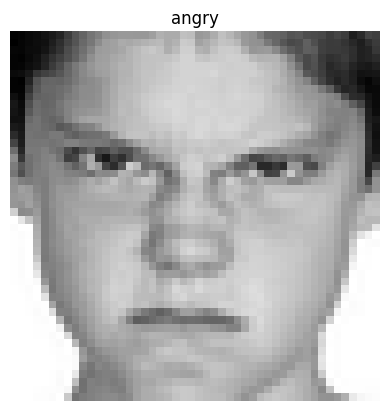

In [ ]:
# View a random image from the training dataset 
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

## Preprocessing our image data

Below, we will import and preprocess FER-2013 dataset into training, validation and test sets. 

In [ ]:
# Preprocessing data with keras function 
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator

# Setting up global variable for preprocessing data 
IMG_SIZE = (48, 48)
BATCH_SIZE = 32 


train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                              validation_split=0.2,
                              color_mode='grayscale',
                              subset="training",
                              seed=512,
                              image_size=IMG_SIZE,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                              validation_split=0.2,
                              color_mode='grayscale',
                              seed=512,
                              subset="validation",
                              image_size=IMG_SIZE,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                              image_size=IMG_SIZE,
                              color_mode='grayscale',
                              batch_size=BATCH_SIZE)


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [ ]:
# Check the classnames agian
class_names

array(['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad',
       'surprised'], dtype='<U9')

In [ ]:
# Check the shape 
for i, l in train_data: 
    print(i.shape)
    print(l.shape)
    break

(32, 48, 48, 1)
(32,)


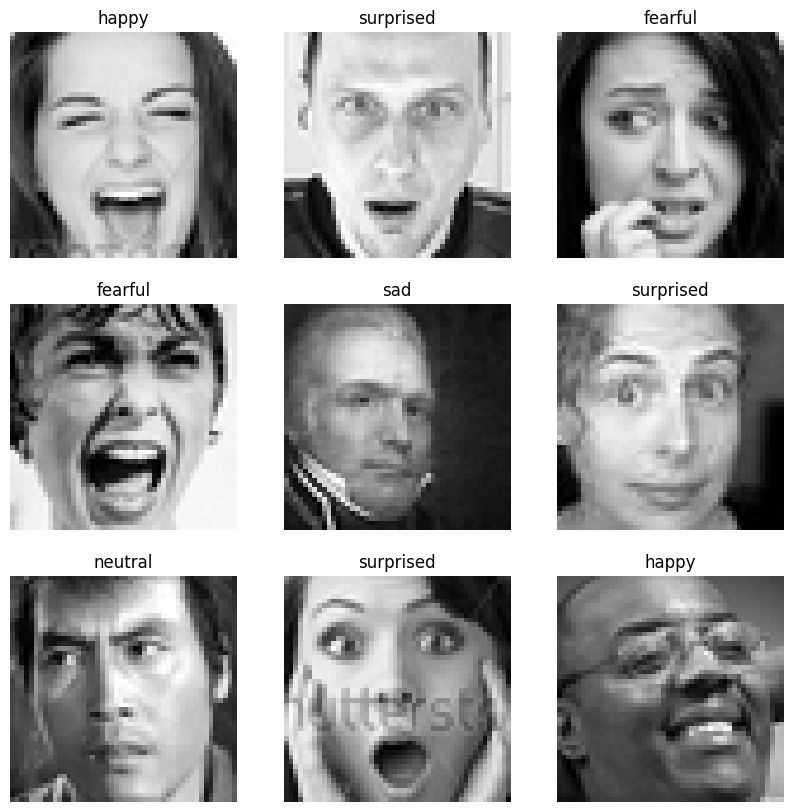

In [ ]:
# Randomly plot 9 images from train_data
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Prefetch trainning and validation dataset for better trainning performance
train_data = train_data.prefetch(tf.data.AUTOTUNE).cache()
val_data = val_data.prefetch(tf.data.AUTOTUNE).cache()

## Running a series of model experiment
Below we will run a series of model experiment to find out which model is suitable in our case. 

- Baseline model: Convolutinal Neural Network(CNN)
- VGG16: A convolutional neural network (CNN) architecture that is widely used in image classification tasks. It has been adapted for use in emotion detection and has achieved high accuracy on several benchmark datasets.
- ResNet: A deep CNN architecture that has shown excellent performance in image classification tasks. It has been used for emotion detection and has achieved high accuracy on several benchmark datasets.
- Inception V3: A CNN architecture that has been used for emotion detection. It is designed to be more computationally efficient than previous CNN architectures and has achieved high accuracy on several benchmark datasets.

For each of the pretrained model, we will: 

1. Run 10 epochs with all layer trainable set to false.
2. Unlock so weights and train for 10 epochs.
3. Add GlobalAveragePooling or Flatten and compare results.
4. Take the best results for model comparison in the end. 

### Baseline model(Basic CNN)

For the baseline model, we choose to use a very basic convolutional neural network. 

In [ ]:
baseline = tf.keras.Sequential([
    tf.keras.Input(shape=(48,48,1)),
    tf.keras.layers.Conv2D(filters=32,
                kernel_size=1,
                activation='relu'),
    tf.keras.layers.Conv2D(64, 2, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,
                padding='valid'),
    tf.keras.layers.Conv2D(64, 2, activation='relu'),
    tf.keras.layers.Conv2D(64, 2, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation='softmax')
])

baseline.compile(loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])

baseline_history = baseline.fit(train_data,
            epochs=10,
            steps_per_epoch=len(train_data),
            validation_data=val_data,
            validation_steps=len(val_data))

Epoch 1/10
718/718 [==============================] - 29s 33ms/step - loss: 1.9783 - accuracy: 0.3008 - val_loss: 1.6802 - val_accuracy: 0.3532
Epoch 2/10
718/718 [==============================] - 4s 5ms/step - loss: 1.5866 - accuracy: 0.3886 - val_loss: 1.5902 - val_accuracy: 0.3872
Epoch 3/10
718/718 [==============================] - 3s 5ms/step - loss: 1.4992 - accuracy: 0.4214 - val_loss: 1.5798 - val_accuracy: 0.3980
Epoch 4/10
718/718 [==============================] - 3s 5ms/step - loss: 1.4422 - accuracy: 0.4534 - val_loss: 1.5924 - val_accuracy: 0.4135
Epoch 5/10
718/718 [==============================] - 3s 5ms/step - loss: 1.3871 - accuracy: 0.4721 - val_loss: 1.5469 - val_accuracy: 0.4288
Epoch 6/10
718/718 [==============================] - 3s 5ms/step - loss: 1.3283 - accuracy: 0.4985 - val_loss: 1.5509 - val_accuracy: 0.4309
Epoch 7/10
718/718 [==============================] - 3s 5ms/step - loss: 1.2632 - accuracy: 0.5259 - val_loss: 1.6179 - val_accuracy: 0.4316
Epoc

In [ ]:
# Plot out loss curves 
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

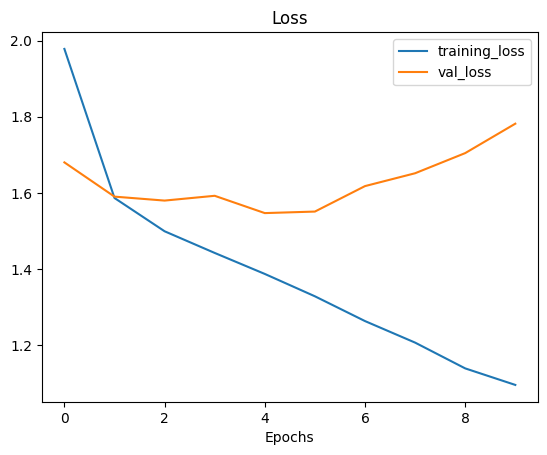

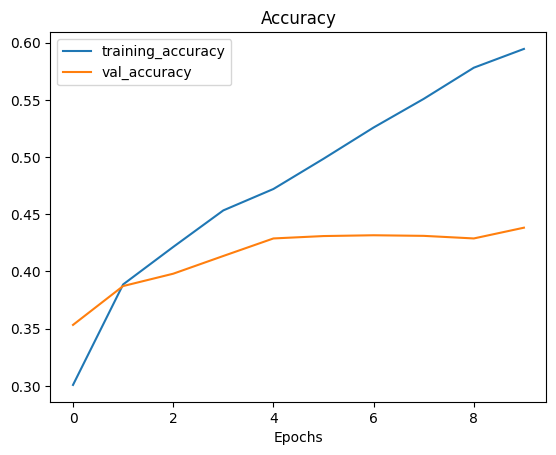

In [ ]:
plot_loss_curves(baseline_history)

In [ ]:
# Evaluating baseline on test_data.
baseline.evaluate(test_data)

225/225 [==============================] - 6s 25ms/step - loss: 1.7534 - accuracy: 0.4473


[1.753393292427063, 0.44733908772468567]

#### Applying data augmentation 
Based on the validation accuracy of our model, it appears that there is some overfitting. In order to address this issue, we will explore the use of data augmentation techniques to increase the diversity of our training data.

In [ ]:
# Apply data augmentation by using `ImageDataGenerator`
train_datagen_augmented = ImageDataGenerator(
                      rotation_range=20, #
                      shear_range=0.2, 
                      zoom_range=0.2, 
                      width_shift_range=0.2, 
                      height_shift_range=0.2, 
                      horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                              target_size=IMG_SIZE,
                              color_mode='grayscale',
                              class_mode='binary',
                              batch_size=BATCH_SIZE,
                              shuffle=True)


Found 28709 images belonging to 7 classes.


In [ ]:
# Check the shape of the augmented data 
for a_i, a_l in train_data_augmented:
    print(a_i.shape)
    print(a_l.shape)
    break

(32, 48, 48, 1)
(32,)


#### Visualize data after data augmentation

Below we will randomly plot one image from original data and one after data augmentation apply. 

In [ ]:
train_data_iter = iter(train_data)
images, labels = next(train_data_iter)
aug_images, aug_labels = train_data_augmented.next()

Showing image number:31


(-0.5, 47.5, 47.5, -0.5)

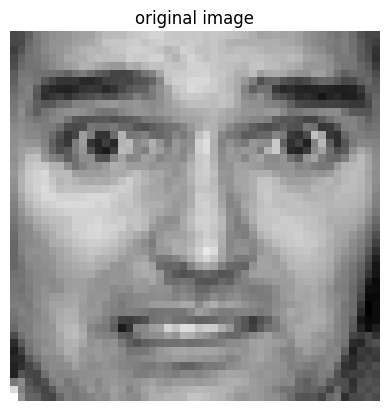

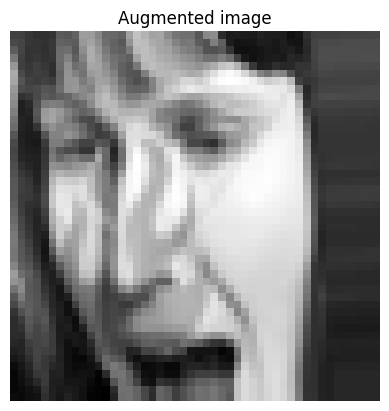

In [ ]:
# Show the original image and the augmented image 
import random
random_number = random.randint(0, 32) #batch size are 32
print(f'Showing image number:{random_number}')
plt.imshow(images[random_number], cmap='gray')
plt.title(f'original image')
plt.axis(False)
plt.figure()
plt.imshow(aug_images[random_number], cmap='gray')
plt.title(f'Augmented image')
plt.axis(False)

#### Fit augmented image data to the same baseline model

In [ ]:
# Apply data augmentation layer into the model 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

baseline_aug_inputs = Input(shape=(48, 48, 1))
x = Conv2D(filters=32, kernel_size=(1, 1), activation='relu')(baseline_aug_inputs)
x = Conv2D(filters=64, kernel_size=(2, 2), activation='relu')(x)
x = MaxPooling2D(pool_size=2, padding='valid')(x)
x = Conv2D(filters=64, kernel_size=(2, 2), activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(2, 2), activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
baseline_aug_outputs = Dense(7, activation='softmax')(x)

baseline_aug = tf.keras.Model(baseline_aug_inputs, baseline_aug_outputs, name='baseline_with_aug_img')
baseline_aug.summary()

Model: "baseline_with_aug_img"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        64        
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 22, 22, 64)        16448     
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        16448     
                                             

In [ ]:
baseline_aug.compile(loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])

baseline_aug_history = baseline_aug.fit(train_data_augmented,
            epochs=10,
            steps_per_epoch=len(train_data_augmented),
            validation_data=val_data,
            validation_steps=len(val_data))

Epoch 1/10
898/898 [==============================] - 15s 16ms/step - loss: 1.9587 - accuracy: 0.2414 - val_loss: 1.7887 - val_accuracy: 0.2681
Epoch 2/10
898/898 [==============================] - 15s 16ms/step - loss: 1.7964 - accuracy: 0.2610 - val_loss: 1.7750 - val_accuracy: 0.2630
Epoch 3/10
898/898 [==============================] - 15s 16ms/step - loss: 1.7847 - accuracy: 0.2624 - val_loss: 1.7792 - val_accuracy: 0.2764
Epoch 4/10
898/898 [==============================] - 14s 16ms/step - loss: 1.7730 - accuracy: 0.2694 - val_loss: 1.7402 - val_accuracy: 0.3045
Epoch 5/10
898/898 [==============================] - 14s 16ms/step - loss: 1.7584 - accuracy: 0.2805 - val_loss: 1.7457 - val_accuracy: 0.3066
Epoch 6/10
898/898 [==============================] - 15s 16ms/step - loss: 1.7422 - accuracy: 0.2903 - val_loss: 1.6619 - val_accuracy: 0.3506
Epoch 7/10
898/898 [==============================] - 15s 16ms/step - loss: 1.7211 - accuracy: 0.3010 - val_loss: 1.6516 - val_accuracy:

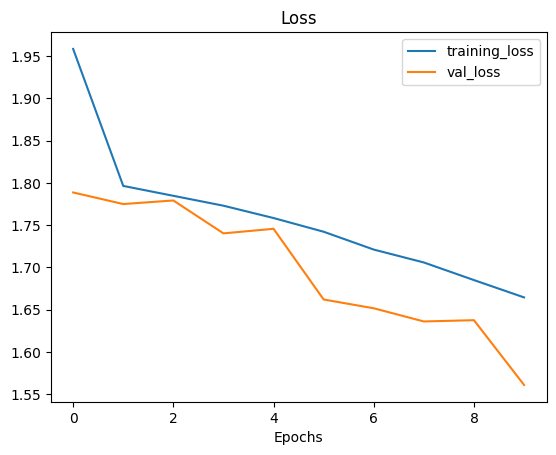

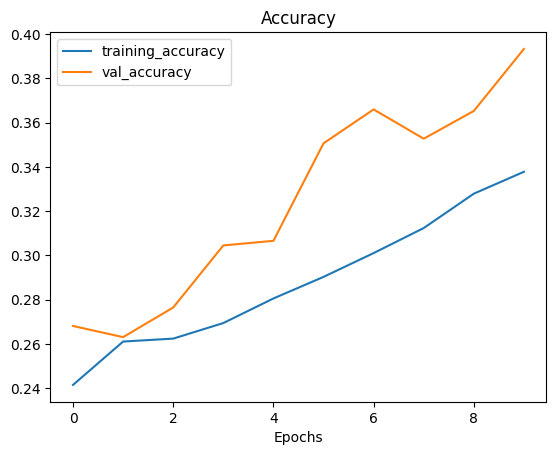

In [ ]:
# Plot the model results
plot_loss_curves(baseline_aug_history)

In [ ]:
# Evaluate the model performance
baseline_aug.evaluate(test_data)

225/225 [==============================] - 1s 4ms/step - loss: 1.5694 - accuracy: 0.3869


[1.5693655014038086, 0.38687655329704285]

It seems like our data augmentation process helped with the overfitting issue. Let's try transferlearning with pre-trained model

### Model_1: VGG 16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))
VGG16.trainable = False # Not trainable weights for now
VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

#### Modify dataset for VGG 16 input

Because the VGG 16 model takes inputs that has 3 color channel. We will modify our dataset below in order to fit the input shape.

In [ ]:
train_datagen_augmented = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data_augmented_vgg = train_datagen_augmented.flow_from_directory(train_dir,
                              target_size=IMG_SIZE,
                              color_mode='rgb',
                              class_mode='binary',
                              batch_size=BATCH_SIZE,
                              shuffle=True)

train_data_vgg = train_datagen.flow_from_directory(train_dir,
                              target_size=IMG_SIZE,
                              color_mode='rgb',
                              class_mode='binary',
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_data_vgg = test_datagen.flow_from_directory(test_dir,
                              target_size=IMG_SIZE,
                              color_mode='rgb',
                              class_mode='binary',
                              batch_size=BATCH_SIZE)

Found 28709 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Check to see if the shape is updated
for i, l in train_data_augmented_vgg:
    print(i.shape)
    break

(32, 48, 48, 3)


#### Create VGG model 
By add a Flatten layer and a dense layer on top

In [ ]:
vgg_model = tf.keras.Sequential([
    VGG16,
    Flatten(),
    Dense(7, activation='softmax')
])

vgg_model.compile(loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 14,718,279
Trainable params: 3,591
Non-trainable params: 14,714,688
_________________________________________________________________


#### Fit VGG model with augmented data

In [ ]:
vgg_history = vgg_model.fit(train_data_augmented_vgg,
            epochs=10,
            steps_per_epoch=len(train_data_augmented_vgg),
            validation_data=test_data_vgg,
            validation_steps=int(0.25*len(test_data_vgg)))

Epoch 1/10
898/898 [==============================] - 10s 10ms/step - loss: 1.6732 - accuracy: 0.3411 - val_loss: 1.5836 - val_accuracy: 0.3923
Epoch 2/10
898/898 [==============================] - 9s 10ms/step - loss: 1.5820 - accuracy: 0.3884 - val_loss: 1.5616 - val_accuracy: 0.3956
Epoch 3/10
898/898 [==============================] - 9s 10ms/step - loss: 1.5516 - accuracy: 0.4007 - val_loss: 1.5657 - val_accuracy: 0.4051
Epoch 4/10
898/898 [==============================] - 9s 10ms/step - loss: 1.5351 - accuracy: 0.4072 - val_loss: 1.5334 - val_accuracy: 0.4001
Epoch 5/10
898/898 [==============================] - 9s 11ms/step - loss: 1.5223 - accuracy: 0.4150 - val_loss: 1.5013 - val_accuracy: 0.4219
Epoch 6/10
898/898 [==============================] - 10s 11ms/step - loss: 1.5137 - accuracy: 0.4184 - val_loss: 1.5096 - val_accuracy: 0.4129
Epoch 7/10
898/898 [==============================] - 11s 12ms/step - loss: 1.5077 - accuracy: 0.4223 - val_loss: 1.5224 - val_accuracy: 0.4

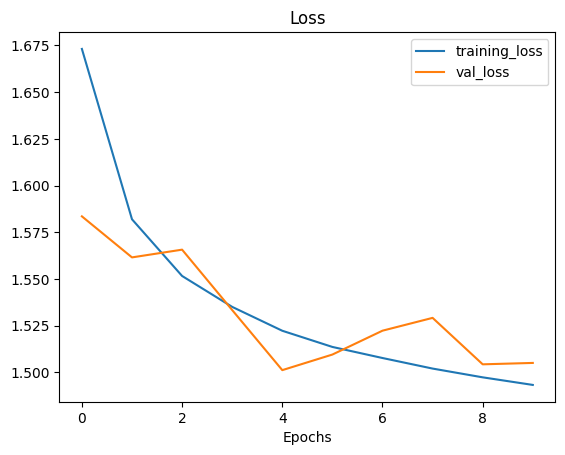

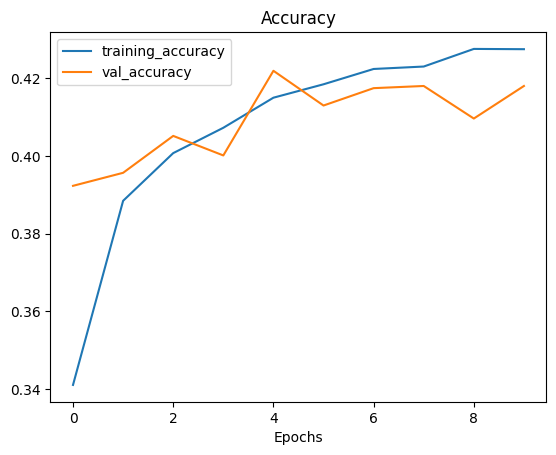

In [ ]:
plot_loss_curves(vgg_history)

In [ ]:
vgg_model.evaluate(test_data_vgg)

225/225 [==============================] - 2s 10ms/step - loss: 1.5201 - accuracy: 0.4138


[1.5200945138931274, 0.41376426815986633]

#### retrained some weights in VGG

In [ ]:
from tensorflow.keras.applications import VGG16

VGG16_unlock = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))
VGG16_unlock.trainable = True 
for layer in VGG16_unlock.layers[:-10]:
  layer.trainable = False
VGG16_unlock.summary(), VGG16_unlock.layers[-11].trainable

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

(None, False)

In [ ]:
vgg_unlock_model = tf.keras.Sequential([
    VGG16_unlock,
    Flatten(),
    Dense(7, activation='softmax')
])

vgg_unlock_model.compile(loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])
vgg_unlock_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 14,718,279
Trainable params: 13,572,871
Non-trainable params: 1,145,408
_________________________________________________________________


In [ ]:
vgg_unlock_history = vgg_unlock_model.fit(train_data_augmented_vgg,
                                            epochs=10,
                                            steps_per_epoch=len(train_data_augmented_vgg),
                                            validation_data=test_data_vgg,
                                            validation_steps=int(0.25*len(test_data_vgg)))

Epoch 1/10
898/898 [==============================] - 14s 14ms/step - loss: 1.5806 - accuracy: 0.3704 - val_loss: 1.4281 - val_accuracy: 0.4314
Epoch 2/10
898/898 [==============================] - 19s 21ms/step - loss: 1.3493 - accuracy: 0.4740 - val_loss: 1.2973 - val_accuracy: 0.4911
Epoch 3/10
898/898 [==============================] - 15s 16ms/step - loss: 1.2568 - accuracy: 0.5162 - val_loss: 1.2460 - val_accuracy: 0.5190
Epoch 4/10
898/898 [==============================] - 13s 15ms/step - loss: 1.1932 - accuracy: 0.5434 - val_loss: 1.2729 - val_accuracy: 0.5095
Epoch 5/10
898/898 [==============================] - 13s 15ms/step - loss: 1.1470 - accuracy: 0.5632 - val_loss: 1.1818 - val_accuracy: 0.5580
Epoch 6/10
898/898 [==============================] - 14s 15ms/step - loss: 1.1036 - accuracy: 0.5811 - val_loss: 1.1858 - val_accuracy: 0.5647
Epoch 7/10
898/898 [==============================] - 13s 15ms/step - loss: 1.0499 - accuracy: 0.6064 - val_loss: 1.2032 - val_accuracy:

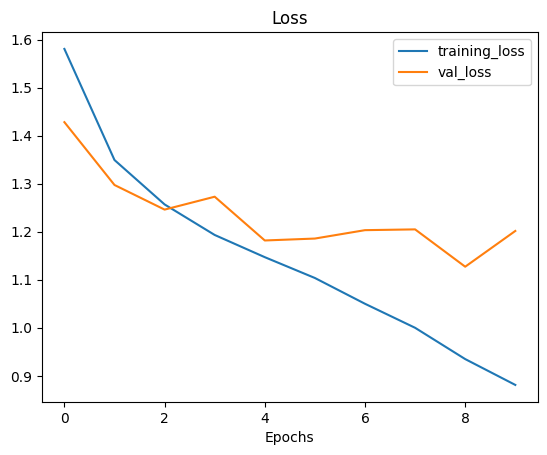

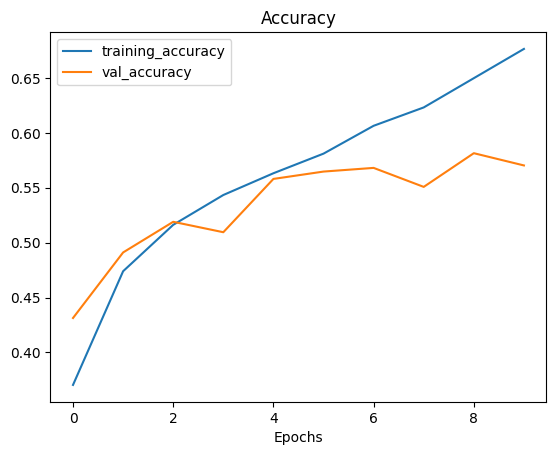

In [ ]:
plot_loss_curves(vgg_unlock_history)

In [ ]:
vgg_unlock_model.evaluate(test_data_vgg)

225/225 [==============================] - 2s 10ms/step - loss: 1.2006 - accuracy: 0.5642


[1.2006105184555054, 0.5642240047454834]

#### Adding another fully connect layer and a dropout layer to prevent overfitting

In [ ]:
from tensorflow.keras.layers import Dropout

vgg_unlock_model_1 = tf.keras.Sequential([
    VGG16_unlock,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

vgg_unlock_model_1.compile(loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])

vgg_unlock_history_1 = vgg_unlock_model_1.fit(train_data_augmented_vgg,
                                            epochs=10,
                                            steps_per_epoch=len(train_data_augmented_vgg),
                                            validation_data=test_data_vgg,
                                            validation_steps=int(0.25*len(test_data_vgg)))

Epoch 1/10
898/898 [==============================] - 14s 15ms/step - loss: 0.8920 - accuracy: 0.6808 - val_loss: 1.2530 - val_accuracy: 0.5647
Epoch 2/10
898/898 [==============================] - 13s 14ms/step - loss: 0.7817 - accuracy: 0.7248 - val_loss: 1.2301 - val_accuracy: 0.6010
Epoch 3/10
898/898 [==============================] - 13s 14ms/step - loss: 0.6978 - accuracy: 0.7563 - val_loss: 1.3988 - val_accuracy: 0.5765
Epoch 4/10
898/898 [==============================] - 13s 15ms/step - loss: 0.6501 - accuracy: 0.7774 - val_loss: 1.4423 - val_accuracy: 0.5731
Epoch 5/10
898/898 [==============================] - 13s 14ms/step - loss: 0.6553 - accuracy: 0.7788 - val_loss: 1.3611 - val_accuracy: 0.5837
Epoch 6/10
898/898 [==============================] - 13s 15ms/step - loss: 0.5521 - accuracy: 0.8156 - val_loss: 1.3668 - val_accuracy: 0.5971
Epoch 7/10
898/898 [==============================] - 13s 15ms/step - loss: 0.4723 - accuracy: 0.8441 - val_loss: 1.5830 - val_accuracy:

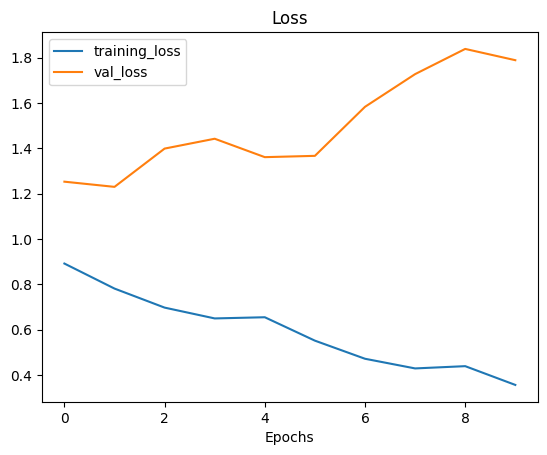

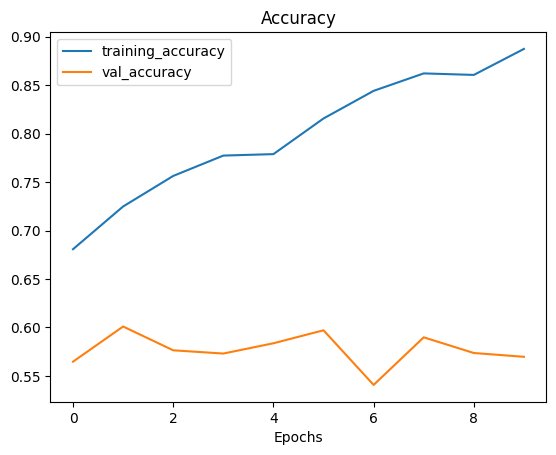

In [ ]:
plot_loss_curves(vgg_unlock_history_1)

In [ ]:
vgg_unlock_model_1.evaluate(test_data_vgg)

225/225 [==============================] - 2s 10ms/step - loss: 1.7316 - accuracy: 0.5748


[1.7316182851791382, 0.5748119354248047]

#### VGG16 with GlobalAveragePooling2D

In [ ]:
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D

vgg_unlock_model_2 = tf.keras.Sequential([
    VGG16_unlock,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

vgg_unlock_model_2.compile(loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])

vgg_unlock_history_2 = vgg_unlock_model_2.fit(train_data_augmented_vgg,
                                            epochs=10,
                                            steps_per_epoch=len(train_data_augmented_vgg),
                                            validation_data=test_data_vgg,
                                            validation_steps=int(0.25*len(test_data_vgg)))

Epoch 1/10
898/898 [==============================] - 14s 15ms/step - loss: 0.3983 - accuracy: 0.8805 - val_loss: 1.6808 - val_accuracy: 0.6016
Epoch 2/10
898/898 [==============================] - 13s 15ms/step - loss: 0.3179 - accuracy: 0.9040 - val_loss: 1.9067 - val_accuracy: 0.6155
Epoch 3/10
898/898 [==============================] - 13s 15ms/step - loss: 0.2837 - accuracy: 0.9135 - val_loss: 1.8065 - val_accuracy: 0.5809
Epoch 4/10
898/898 [==============================] - 13s 15ms/step - loss: 0.2864 - accuracy: 0.9154 - val_loss: 1.7288 - val_accuracy: 0.5993
Epoch 5/10
898/898 [==============================] - 13s 15ms/step - loss: 0.2407 - accuracy: 0.9295 - val_loss: 2.1962 - val_accuracy: 0.5798
Epoch 6/10
898/898 [==============================] - 14s 15ms/step - loss: 0.2517 - accuracy: 0.9238 - val_loss: 2.2652 - val_accuracy: 0.5770
Epoch 7/10
898/898 [==============================] - 14s 15ms/step - loss: 0.2614 - accuracy: 0.9227 - val_loss: 2.0793 - val_accuracy:

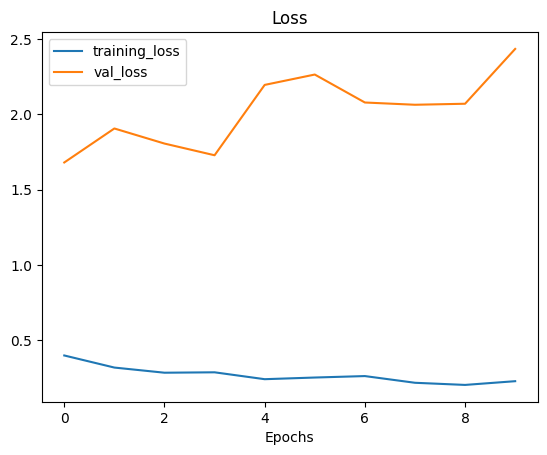

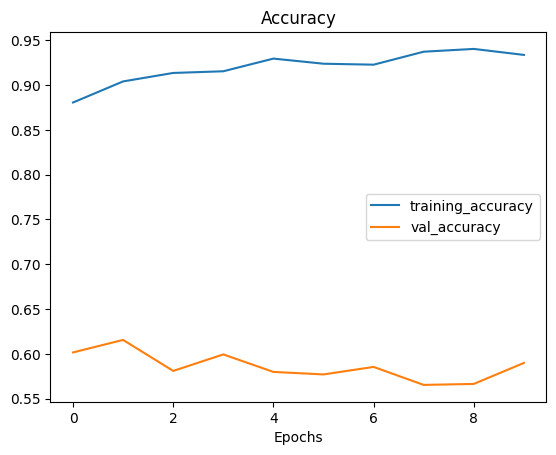

In [ ]:
plot_loss_curves(vgg_unlock_history_2)

In [ ]:
vgg_unlock_model_2.evaluate(test_data_vgg)

225/225 [==============================] - 2s 10ms/step - loss: 2.4931 - accuracy: 0.5756


[2.493055582046509, 0.5756478309631348]

### Model 2: ResNet model

In [ ]:
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet152V2

resnet = ResNet152V2(weights="imagenet", include_top=False, input_shape=(48, 48, 3))
resnet.trainable = False # Not trainable weights for now
resnet.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 26, 26, 64)   0           ['conv1_conv[0][0]']             
                                                                                        

#### ResNet with GlobalAveragePooling2D()

In [ ]:
resnet_model = tf.keras.Sequential([
        resnet,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
])

In [ ]:
resnet_model.compile(loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])

# Using train_data_augmented_vgg here is because I updated the dataset shape from (48, 48, 1) 
# to (48, 48, 3) for vgg, however it fits to resnet also. 
resnet_history = resnet_model.fit(train_data_augmented_vgg,
                                  epochs=10,
                                  steps_per_epoch=len(train_data_augmented_vgg),
                                  validation_data=test_data_vgg,
                                  validation_steps=int(0.25*len(test_data_vgg)))

Epoch 1/10
898/898 [==============================] - 31s 27ms/step - loss: 1.7985 - accuracy: 0.3085 - val_loss: 1.6298 - val_accuracy: 0.3510
Epoch 2/10
898/898 [==============================] - 22s 25ms/step - loss: 1.6507 - accuracy: 0.3558 - val_loss: 1.6072 - val_accuracy: 0.3594
Epoch 3/10
898/898 [==============================] - 22s 24ms/step - loss: 1.6087 - accuracy: 0.3721 - val_loss: 1.5479 - val_accuracy: 0.4012
Epoch 4/10
898/898 [==============================] - 21s 24ms/step - loss: 1.5755 - accuracy: 0.3872 - val_loss: 1.5607 - val_accuracy: 0.3839
Epoch 5/10
898/898 [==============================] - 21s 24ms/step - loss: 1.5446 - accuracy: 0.4006 - val_loss: 1.5470 - val_accuracy: 0.3990
Epoch 6/10
898/898 [==============================] - 22s 24ms/step - loss: 1.5178 - accuracy: 0.4118 - val_loss: 1.5433 - val_accuracy: 0.4001
Epoch 7/10
898/898 [==============================] - 23s 26ms/step - loss: 1.4961 - accuracy: 0.4228 - val_loss: 1.5666 - val_accuracy:

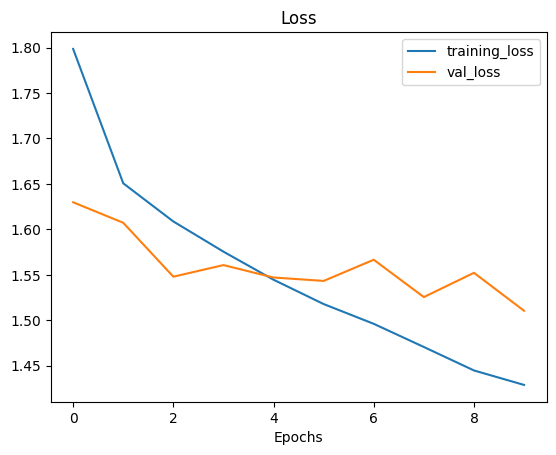

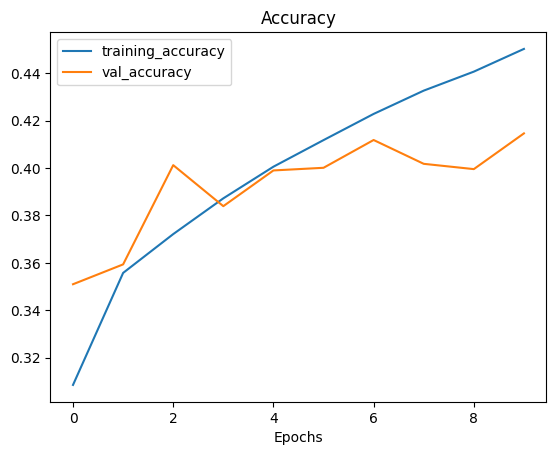

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
resnet_model.evaluate(test_data_vgg)

225/225 [==============================] - 5s 23ms/step - loss: 1.5246 - accuracy: 0.4133


[1.5246118307113647, 0.4133463501930237]

#### ResNet with Flatten()

In [ ]:
resnet_model_flatten = tf.keras.Sequential([
        resnet,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
])

resnet_model_flatten.compile(loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])

# Using train_data_augmented_vgg here is because I updated the dataset shape from (48, 48, 1) 
# to (48, 48, 3) for vgg, however it fits to resnet also. 
resnet_model_flatten_history = resnet_model_flatten.fit(train_data_augmented_vgg,
                                                      epochs=10,
                                                      steps_per_epoch=len(train_data_augmented_vgg),
                                                      validation_data=test_data_vgg,
                                                      validation_steps=int(0.25*len(test_data_vgg)))

Epoch 1/10
898/898 [==============================] - 30s 26ms/step - loss: 1.8759 - accuracy: 0.2908 - val_loss: 1.6254 - val_accuracy: 0.3672
Epoch 2/10
898/898 [==============================] - 22s 25ms/step - loss: 1.6868 - accuracy: 0.3309 - val_loss: 1.5916 - val_accuracy: 0.3828
Epoch 3/10
898/898 [==============================] - 22s 25ms/step - loss: 1.6363 - accuracy: 0.3511 - val_loss: 1.5998 - val_accuracy: 0.3761
Epoch 4/10
898/898 [==============================] - 22s 25ms/step - loss: 1.6065 - accuracy: 0.3602 - val_loss: 1.6138 - val_accuracy: 0.3850
Epoch 5/10
898/898 [==============================] - 23s 25ms/step - loss: 1.5788 - accuracy: 0.3735 - val_loss: 1.6157 - val_accuracy: 0.3761
Epoch 6/10
898/898 [==============================] - 22s 25ms/step - loss: 1.5498 - accuracy: 0.3861 - val_loss: 1.5311 - val_accuracy: 0.4314
Epoch 7/10
898/898 [==============================] - 22s 24ms/step - loss: 1.5334 - accuracy: 0.3893 - val_loss: 1.5517 - val_accuracy:

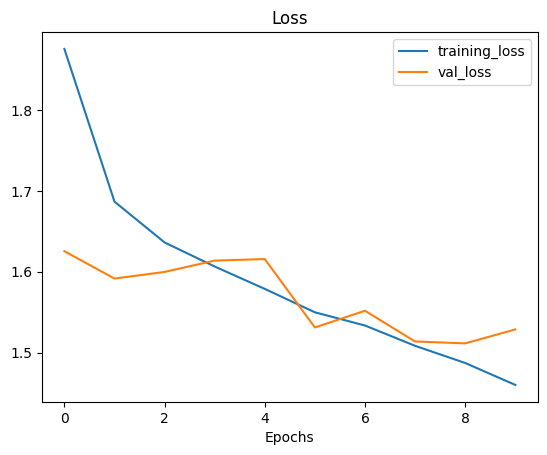

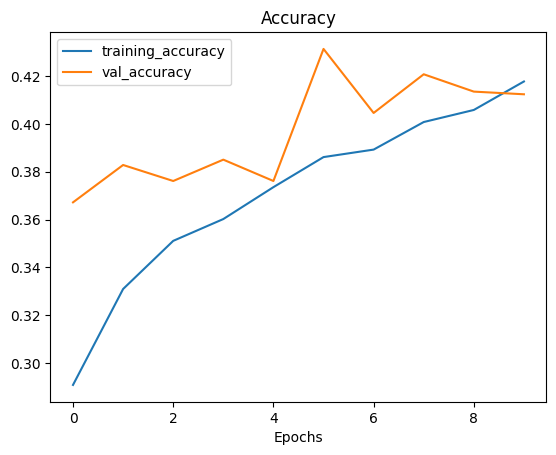

In [ ]:
plot_loss_curves(resnet_model_flatten_history)

In [ ]:
resnet_model_flatten.evaluate(test_data_vgg)

225/225 [==============================] - 5s 22ms/step - loss: 1.5113 - accuracy: 0.4185


[1.5113335847854614, 0.41850098967552185]

#### Retrained some weights in ResNet
Seems like the GlobalAveragePooling and Flatten didn't make change, we will choose either one for below cases. 

In [ ]:
# Unlock last 10 layers of resnet to make it trainable
resnet_unlock = ResNet152V2(weights="imagenet", include_top=False, input_shape=(48, 48, 3))
resnet_unlock.trainable = True 
for layer in resnet_unlock.layers[:-10]:
  layer.trainable = False
resnet_unlock.layers[-10].trainable

True

In [ ]:
resnet_unlock_model = tf.keras.Sequential([
        resnet_unlock,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
])

resnet_unlock_model.compile(loss='sparse_categorical_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])

# Using train_data_augmented_vgg here is because I updated the dataset shape from (48, 48, 1) 
# to (48, 48, 3) for vgg, however it fits to resnet also. 
resnet_unlock_model_history = resnet_unlock_model.fit(train_data_augmented_vgg,
                                                      epochs=10,
                                                      steps_per_epoch=len(train_data_augmented_vgg),
                                                      validation_data=test_data_vgg,
                                                      validation_steps=int(0.25*len(test_data_vgg)))

Epoch 1/10
898/898 [==============================] - 32s 29ms/step - loss: 1.6452 - accuracy: 0.3631 - val_loss: 1.5100 - val_accuracy: 0.4096
Epoch 2/10
898/898 [==============================] - 23s 26ms/step - loss: 1.5148 - accuracy: 0.4211 - val_loss: 1.5171 - val_accuracy: 0.4275
Epoch 3/10
898/898 [==============================] - 23s 26ms/step - loss: 1.4210 - accuracy: 0.4537 - val_loss: 1.4798 - val_accuracy: 0.4353
Epoch 4/10
898/898 [==============================] - 24s 26ms/step - loss: 1.3271 - accuracy: 0.4944 - val_loss: 1.4403 - val_accuracy: 0.4732
Epoch 5/10
898/898 [==============================] - 24s 27ms/step - loss: 1.1973 - accuracy: 0.5482 - val_loss: 1.5344 - val_accuracy: 0.4408
Epoch 6/10
898/898 [==============================] - 26s 29ms/step - loss: 1.0502 - accuracy: 0.6051 - val_loss: 1.5679 - val_accuracy: 0.4386
Epoch 7/10
898/898 [==============================] - 25s 28ms/step - loss: 0.8820 - accuracy: 0.6717 - val_loss: 1.6735 - val_accuracy:

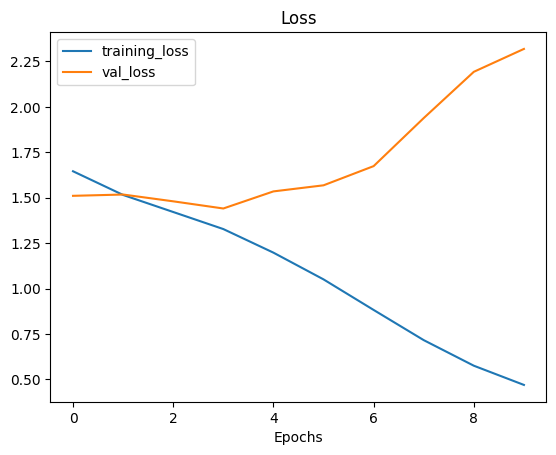

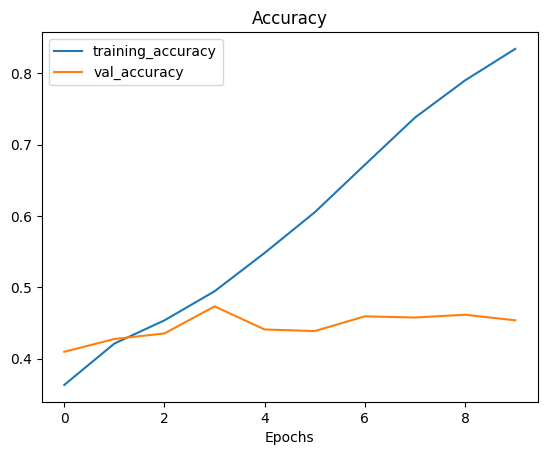

In [ ]:
plot_loss_curves(resnet_unlock_model_history)

In [ ]:
resnet_unlock_model.evaluate(test_data_vgg)

225/225 [==============================] - 6s 24ms/step - loss: 2.3184 - accuracy: 0.4634


[2.3184099197387695, 0.4633602797985077]

### Model 3: Inception ResNetV2

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

inception = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(75, 75, 3))
inception.trainable = False # Not trainable weights for now
inception.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 37, 37, 32)   864         ['input_7[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d_8[0][0]']               
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normali

#### Modify data for Inception ResNetV2
Because Inception V3's minimal input shape is (75, 75, 3), we will need to further preprocess our dataset. 

In [ ]:
train_data_augmented_inception = train_datagen_augmented.flow_from_directory(train_dir,
                              target_size=(75, 75),
                              color_mode='rgb',
                              class_mode='binary',
                              batch_size=BATCH_SIZE,
                              shuffle=True)


test_data_inception = test_datagen.flow_from_directory(test_dir,
                              target_size=(75, 75),
                              color_mode='rgb',
                              class_mode='binary',
                              batch_size=BATCH_SIZE)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


#### Fit Inception model

In [ ]:
inception_model = tf.keras.Sequential([
        inception,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
])

inception_model.compile(loss='sparse_categorical_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])

# Using train_data_augmented_vgg here is because I updated the dataset shape from (48, 48, 1) 
# to (48, 48, 3) for vgg, however it fits to resnet also. 
inception_model_history = inception_model.fit(train_data_augmented_inception,
                                              epochs=10,
                                              steps_per_epoch=len(train_data_augmented_inception),
                                              validation_data=test_data_inception,
                                              validation_steps=int(0.25*len(test_data_inception)))

Epoch 1/10
898/898 [==============================] - 37s 33ms/step - loss: 1.7739 - accuracy: 0.3136 - val_loss: 1.6219 - val_accuracy: 0.3560
Epoch 2/10
898/898 [==============================] - 26s 29ms/step - loss: 1.6405 - accuracy: 0.3569 - val_loss: 1.5475 - val_accuracy: 0.3996
Epoch 3/10
898/898 [==============================] - 26s 29ms/step - loss: 1.6019 - accuracy: 0.3751 - val_loss: 1.5263 - val_accuracy: 0.4180
Epoch 4/10
898/898 [==============================] - 26s 29ms/step - loss: 1.5851 - accuracy: 0.3817 - val_loss: 1.5251 - val_accuracy: 0.4180
Epoch 5/10
898/898 [==============================] - 26s 29ms/step - loss: 1.5696 - accuracy: 0.3907 - val_loss: 1.4758 - val_accuracy: 0.4442
Epoch 6/10
898/898 [==============================] - 26s 29ms/step - loss: 1.5563 - accuracy: 0.3986 - val_loss: 1.4558 - val_accuracy: 0.4570
Epoch 7/10
898/898 [==============================] - 27s 30ms/step - loss: 1.5434 - accuracy: 0.4015 - val_loss: 1.4842 - val_accuracy:

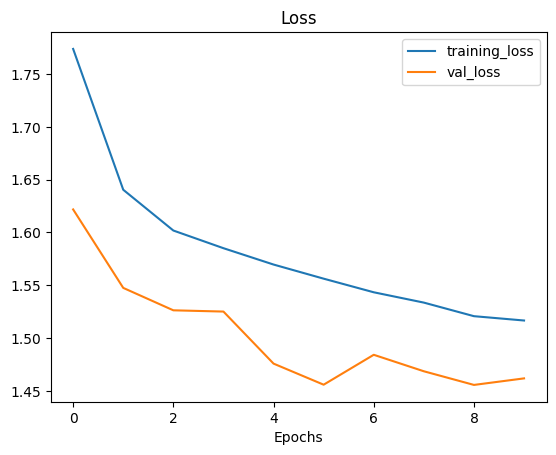

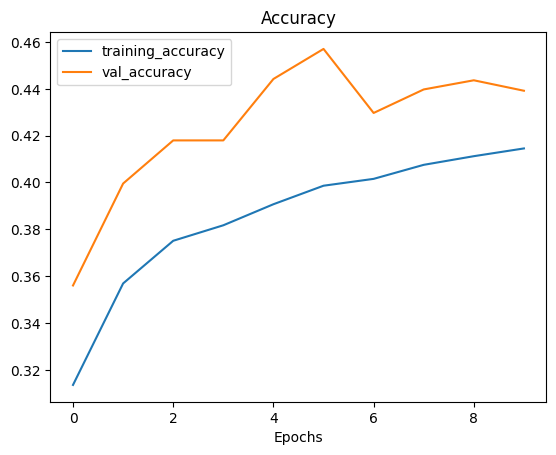

In [ ]:
plot_loss_curves(inception_model_history)

In [ ]:
inception_model.evaluate(test_data_inception)

225/225 [==============================] - 6s 27ms/step - loss: 1.4563 - accuracy: 0.4413


[1.4562948942184448, 0.4413485527038574]

#### Retrained some weights in inception

In [ ]:
inception_unlock = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(75, 75, 3))
inception_unlock.trainable = True 
for layer in inception_unlock.layers[:-10]:
  layer.trainable = False
inception_unlock.layers[-10].trainable

True

In [ ]:
inception_unlock_model = tf.keras.Sequential([
                inception_unlock,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
])

inception_unlock_model.compile(loss='sparse_categorical_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])


inception_unlock_model_history = inception_unlock_model.fit(train_data_augmented_inception,
                                              epochs=10,
                                              steps_per_epoch=len(train_data_augmented_inception),
                                              validation_data=test_data_inception,
                                              validation_steps=int(0.25*len(test_data_inception)))

Epoch 1/10
898/898 [==============================] - 37s 32ms/step - loss: 1.7078 - accuracy: 0.3402 - val_loss: 1.5679 - val_accuracy: 0.3990
Epoch 2/10
898/898 [==============================] - 27s 30ms/step - loss: 1.6062 - accuracy: 0.3805 - val_loss: 1.5146 - val_accuracy: 0.4169
Epoch 3/10
898/898 [==============================] - 27s 30ms/step - loss: 1.5743 - accuracy: 0.3944 - val_loss: 1.4991 - val_accuracy: 0.4230
Epoch 4/10
898/898 [==============================] - 27s 30ms/step - loss: 1.5409 - accuracy: 0.4083 - val_loss: 1.4615 - val_accuracy: 0.4336
Epoch 5/10
898/898 [==============================] - 27s 30ms/step - loss: 1.5114 - accuracy: 0.4177 - val_loss: 1.4612 - val_accuracy: 0.4364
Epoch 6/10
898/898 [==============================] - 27s 30ms/step - loss: 1.4808 - accuracy: 0.4323 - val_loss: 1.4397 - val_accuracy: 0.4660
Epoch 7/10
898/898 [==============================] - 27s 30ms/step - loss: 1.4553 - accuracy: 0.4404 - val_loss: 1.4305 - val_accuracy:

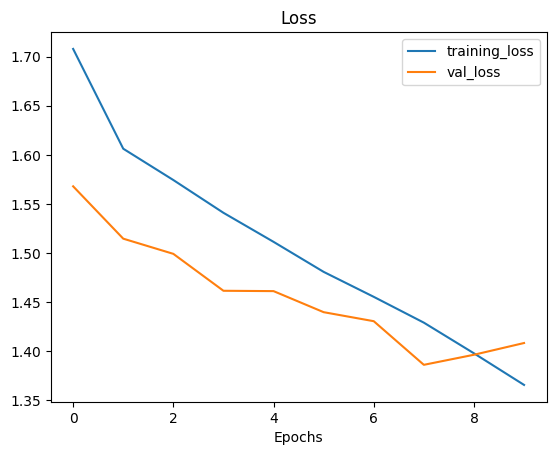

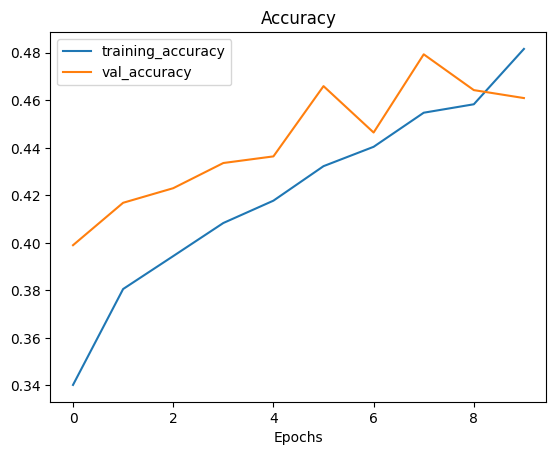

In [ ]:
plot_loss_curves(inception_unlock_model_history)

In [ ]:
inception_unlock_model.evaluate(test_data_inception)

225/225 [==============================] - 6s 24ms/step - loss: 1.4056 - accuracy: 0.4673


[1.4055694341659546, 0.46726107597351074]

### Model comparison

comparing models with their validation loss and validation accuracy

In [ ]:
def compare_models(history, history1, history2, history3):

  val_loss = history.history['val_loss']
  val_loss1 = history1.history['val_loss']
  val_loss2 = history2.history['val_loss']
  val_loss3 = history3.history['val_loss']
    
  val_accuracy = history.history['val_accuracy']
  val_accuracy1 = history1.history['val_accuracy']
  val_accuracy2 = history2.history['val_accuracy']
  val_accuracy3 = history3.history['val_accuracy']
    
  epochs = range(len(history.history['loss']))
  epochs1 = range(len(history1.history['loss']))
  epochs2 = range(len(history2.history['loss']))
  epochs3 = range(len(history3.history['loss']))


  # Plot loss
  plt.plot(epochs, val_loss, label='baseline val_loss')
  plt.plot(epochs1, val_loss1, label='vgg16 val_loss')
  plt.plot(epochs2, val_loss2, label='resnet val_loss')
  plt.plot(epochs3, val_loss3, label='inception val_loss')  
  plt.title("Compare Best perform models' val Loss")
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, val_accuracy, label='baseline val_accuracy')
  plt.plot(epochs1, val_accuracy1, label='vgg16 val_accuracy')
  plt.plot(epochs2, val_accuracy2, label='resnet val_accuracy')
  plt.plot(epochs3, val_accuracy3, label='inception val_accuracy')
  plt.title("Compare Best perform models' Val Accuracy")
  plt.xlabel('Epochs')
  plt.legend();

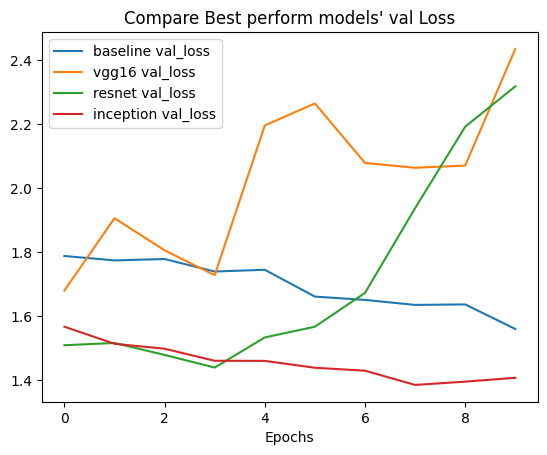

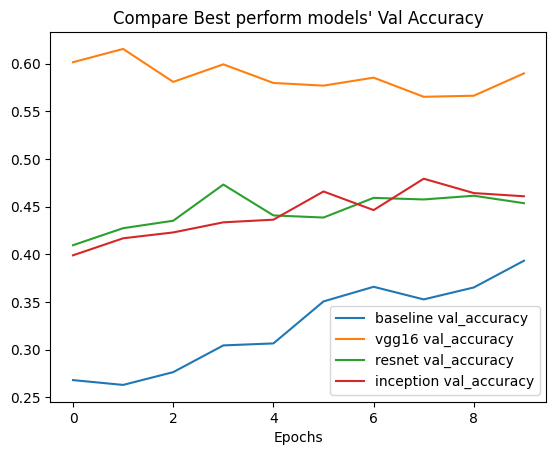

In [ ]:
compare_models(baseline_aug_history, vgg_unlock_history_2, resnet_unlock_model_history, inception_unlock_model_history)

In results, VGG16 performs best of all. We will trained VGG 16 in the next part to better adapt our task.